In [34]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Rescaling, UpSampling2D
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
image_dir = "/content/gdrive/My Drive//data/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/images"

input_img_paths = sorted([os.path.join(image_dir, fname)
                          for fname in os.listdir(image_dir)
                          if not (('fuse' in fname) or ('save' in fname))])
target_img_paths = sorted([os.path.join(image_dir, fname)
                           for fname in os.listdir(image_dir)
                           if 'fuse' in fname])

In [5]:
# Making a function to load the data:
def data_loader(folder_dir):
    image_dataset = []
    mask_dataset = []
    for images in sorted(os.listdir(folder_dir)):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)

        if 'fuse' in images:
            mask_dataset.append(image)
        elif 'fuse' not in images and 'save' not in images:
            image_dataset.append(image)

    return image_dataset, mask_dataset



In [6]:
image_dataset, mask_dataset = data_loader(image_dir)

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [8]:
mask_dataset.shape

(200, 128, 128, 3)

In [9]:
len(image_dataset)

200

In [10]:
len(mask_dataset)

200

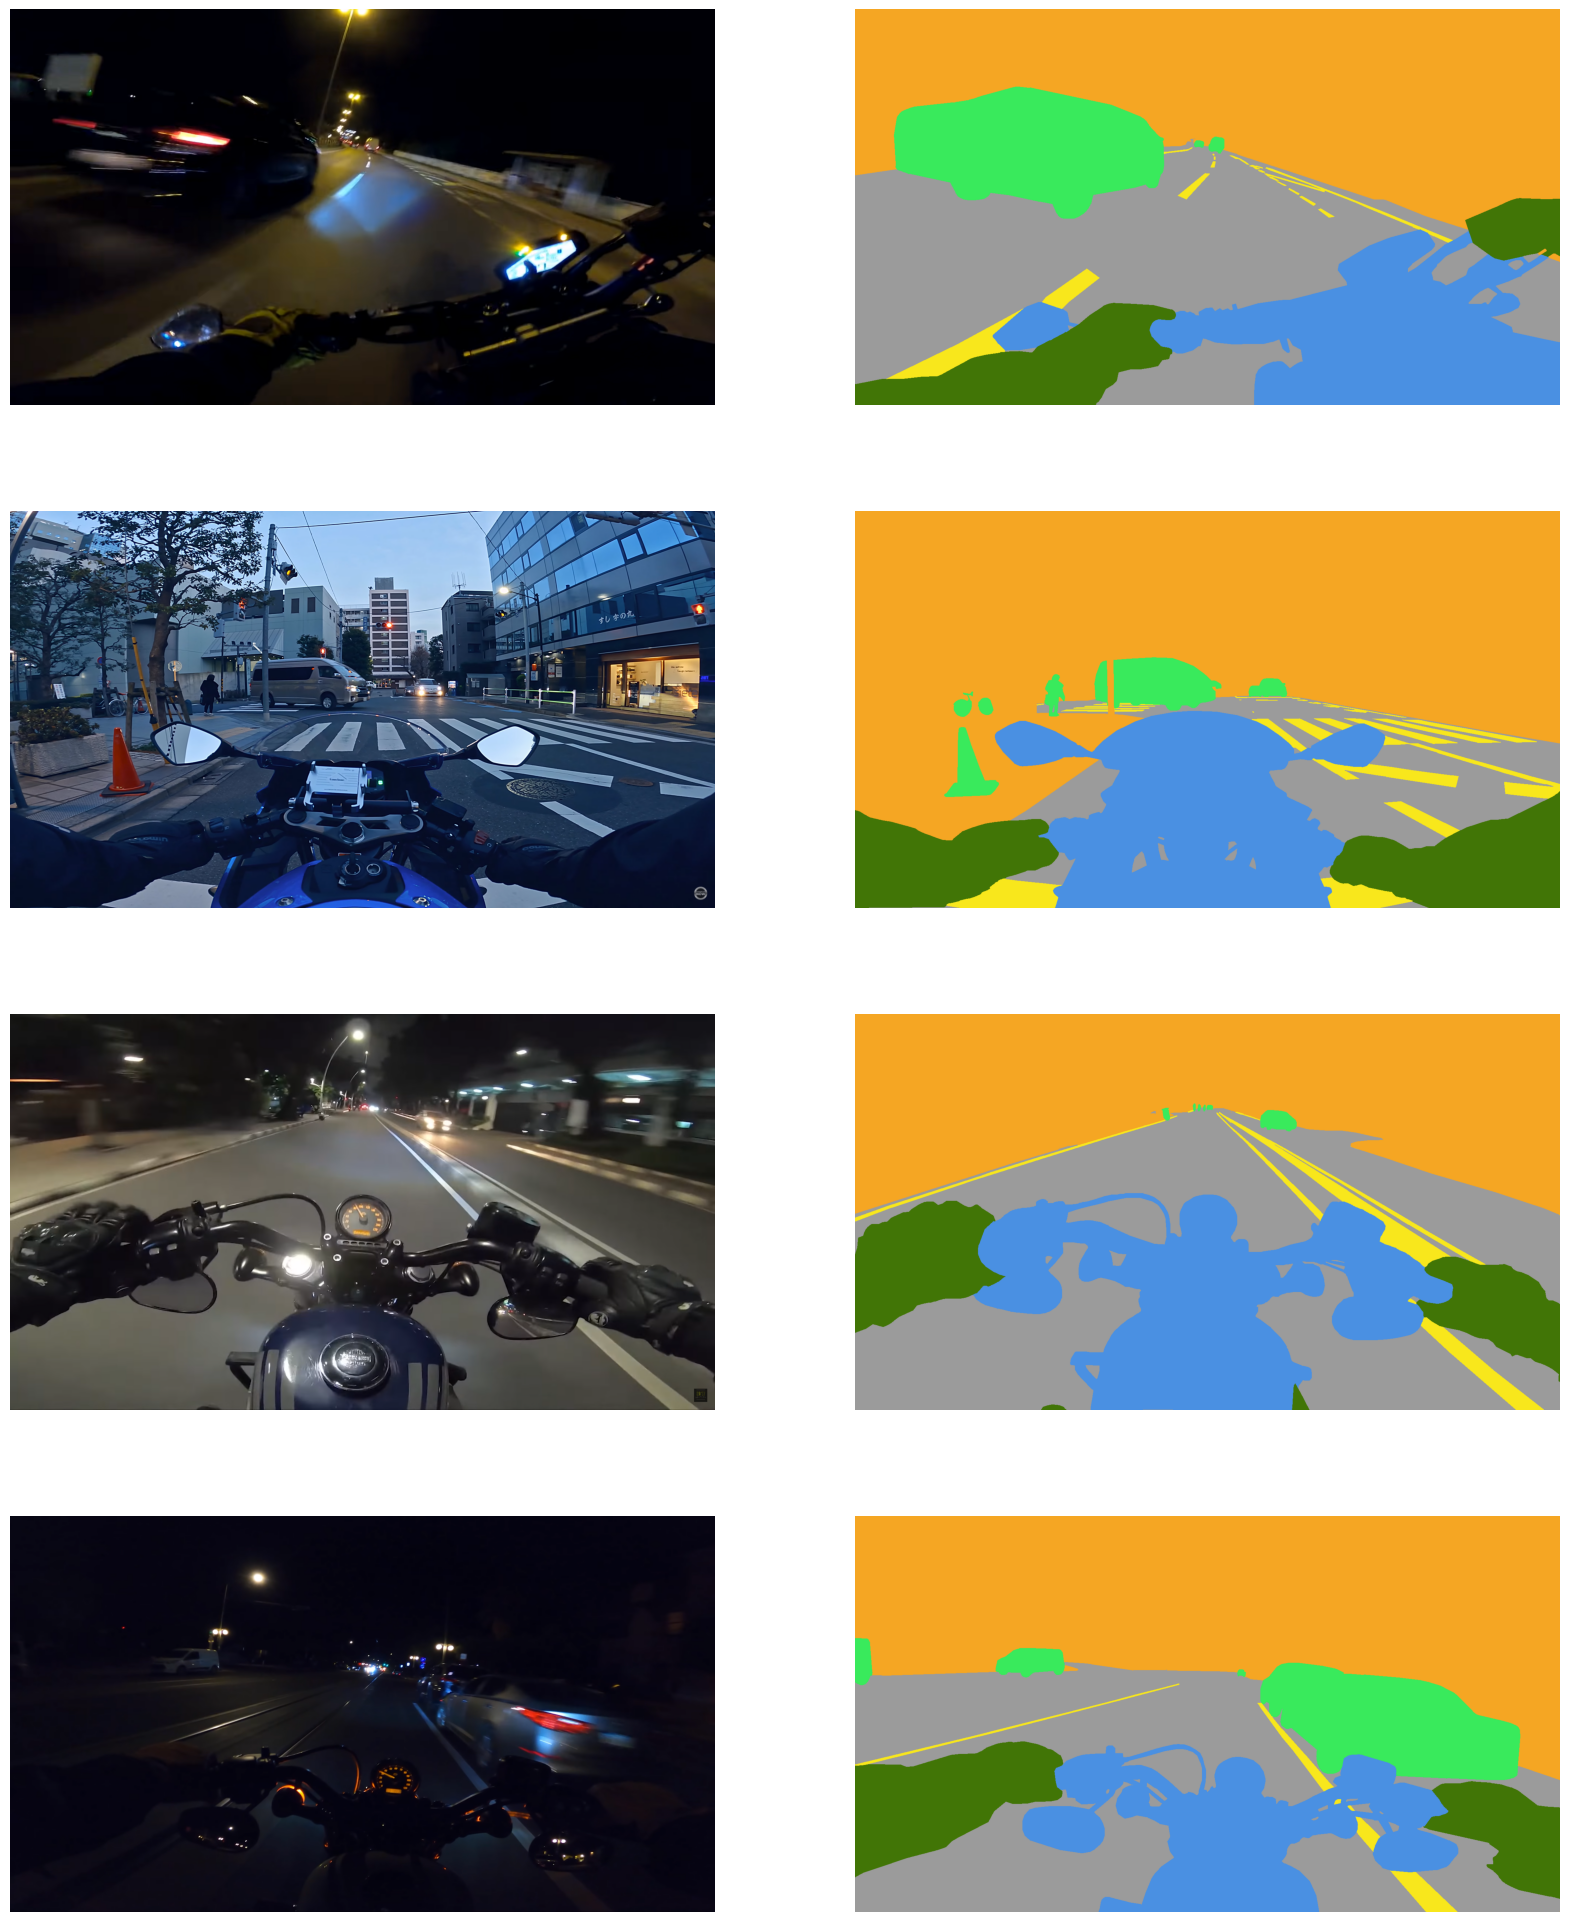

In [11]:
# 데이터 직접 확인

plt.figure(figsize=(20,25))
for j in range(4):
    plt.subplot(4,2,2*j+1)
    plt.axis("off")
    plt.imshow(load_img(input_img_paths[j*50]))
    plt.subplot(4,2,2*j+2)
    plt.axis("off")
    plt.imshow(load_img(target_img_paths[j*50]))

In [12]:
# 타겟 데이터의 내부 값 확인
import numpy as np

target = load_img(target_img_paths[0], color_mode='grayscale')
target = img_to_array(target)
target = target.astype("uint8")
color = np.unique(target)
color

array([ 89, 132, 155, 165, 175, 213], dtype=uint8)

In [13]:
dict_color_to_label = dict()
dict_label_to_color = dict()
for i in range(6):
    i = np.uint8(i)
    dict_color_to_label[color[i]] = i
    dict_label_to_color[i] = color[i]

In [14]:
type(dict_color_to_label[89])

numpy.uint8

In [15]:
# 이미지 크기 확인
img = load_img(input_img_paths[0])
img.size

(1920, 1080)

In [16]:
img_size = (272, 480) # 리스케일링 비율은 원본과 최대한 가깝게 유지하되, UNet 모델에서 MaxPooling을 4번 적용 가능한 정수 비율을 적용
num_imgs = len(input_img_paths)

# 데이터 셔플 및 전처리
random.Random(100).shuffle(input_img_paths)
random.Random(100).shuffle(target_img_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8")
    for val in color:
        img = np.where(img==val, dict_color_to_label[val], img)
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_img_paths[i])

In [17]:

# 학습, 검증, 테스트 데이터 분할

num_test_samples = 20
num_val_samples = 20
train_input_imgs = input_imgs[:-(num_test_samples + num_val_samples)]
train_targets = targets[:-(num_test_samples + num_val_samples)]
val_input_imgs = input_imgs[-(num_test_samples + num_val_samples):-num_test_samples]
val_targets = targets[-(num_test_samples + num_val_samples):-num_test_samples]
test_input_imgs = input_imgs[-num_test_samples:]
test_targets = targets[-num_test_samples:]

In [52]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # 첫 번째 레이어
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # 두 번째 레이어
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def get_model(input_img, num_classes, n_filters=16, dropout=0.5, batchnorm=True):

    rs = Rescaling(1./255)(input_img)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(rs)
    c1 = conv2d_block(c1, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)

    # 중간 Path
    c2 = conv2d_block(p1, n_filters=n_filters*2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv2d_block(p2, n_filters=n_filters*4)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv2d_block(p3, n_filters=n_filters*8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv2d_block(p4, n_filters=n_filters*16)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same', activation='relu')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8)

    u7 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same', activation='relu')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same', activation='relu')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2)

    # Expansive Path
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same', activation='relu')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(c9)
    model = Model(inputs=input_img, outputs=outputs)
    return model

input_img = Input((272, 480, 3), name='img')
model = get_model(input_img, num_classes=6, n_filters=16, dropout=0.1, batchnorm=True)



In [49]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 272, 480, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 272, 480, 3)          0         ['img[0][0]']                 
                                                                                                  
 conv2d_169 (Conv2D)         (None, 272, 480, 64)         1792      ['rescaling_7[0][0]']         
                                                                                                  
 conv2d_170 (Conv2D)         (None, 272, 480, 16)         9232      ['conv2d_169[0][0]']          
                                                                                            

In [55]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [TensorBoard(log_dir='./log'), ModelCheckpoint("segmentation.h5", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=16,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/100
10/10 [==============================] - 13s 284ms/step - loss: 0.1036 - accuracy: 0.9636 - val_loss: 0.4193 - val_accuracy: 0.8952
Epoch 2/100
10/10 [==============================] - 2s 198ms/step - loss: 0.0950 - accuracy: 0.9652 - val_loss: 0.5242 - val_accuracy: 0.8875
Epoch 3/100
10/10 [==============================] - 2s 198ms/step - loss: 0.0792 - accuracy: 0.9709 - val_loss: 0.4908 - val_accuracy: 0.8835
Epoch 4/100
10/10 [==============================] - 2s 225ms/step - loss: 0.0661 - accuracy: 0.9754 - val_loss: 0.4174 - val_accuracy: 0.8979
Epoch 5/100
10/10 [==============================] - 2s 198ms/step - loss: 0.0617 - accuracy: 0.9767 - val_loss: 0.4496 - val_accuracy: 0.8958
Epoch 6/100
10/10 [==============================] - 2s 199ms/step - loss: 0.0623 - accuracy: 0.9765 - val_loss: 0.4367 - val_accuracy: 0.9005
Epoch 7/100
10/10 [==============================] - 2s 198ms/step - loss: 0.0570 - accuracy: 0.9785 - val_loss: 0.4297 - val_accuracy: 0.897

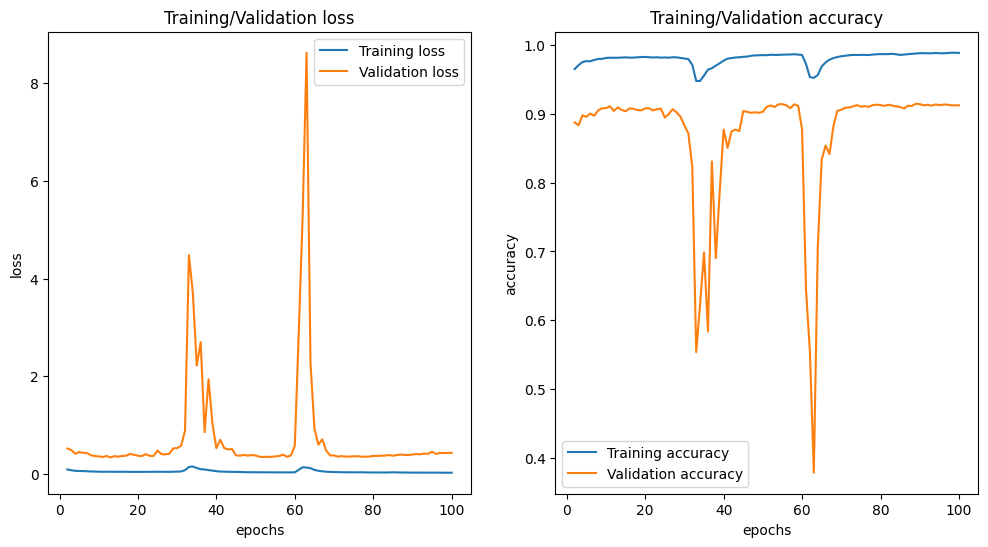

In [56]:
# 결과 시각화


epochs = range(1, len(history.history["loss"]) + 1)[1:]
loss = history.history["loss"][1:]
val_loss = history.history["val_loss"][1:]
acc = history.history["accuracy"][1:]
val_acc = history.history["val_accuracy"][1:]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training/Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training/Validation accuracy")
plt.legend()

In [57]:
### 모델 정의 및 학습

# 모델 정의


def get_model(img_size, num_classes):

    inputs = Input(shape=img_size + (3,))
    rs = Rescaling(1./255)(inputs)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(rs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(c9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = get_model(img_size=img_size, num_classes=6)
model.summary()

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [TensorBoard(log_dir='./log'), ModelCheckpoint("segmentation.h5", save_best_only=True), EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
history = model.fit(train_input_imgs, train_targets,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=16,
                    validation_data=(val_input_imgs, val_targets))

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 272, 480, 3)]        0         []                            
                                                                                                  
 rescaling_10 (Rescaling)    (None, 272, 480, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv2d_212 (Conv2D)         (None, 272, 480, 64)         1792      ['rescaling_10[0][0]']        
                                                                                                  
 conv2d_213 (Conv2D)         (None, 272, 480, 64)         36928     ['conv2d_212[0][0]']          
                                                                                            

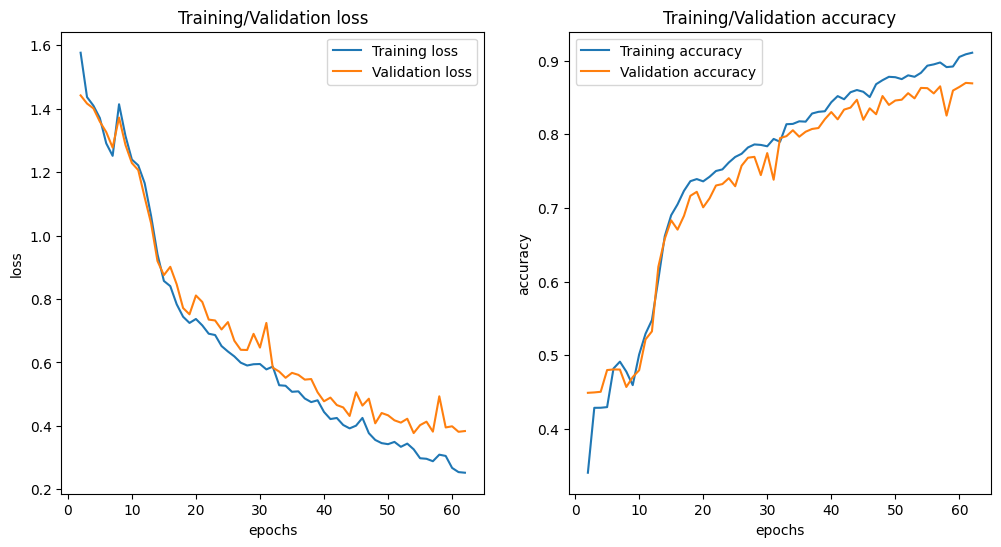

In [58]:
# 결과 시각화


epochs = range(1, len(history.history["loss"]) + 1)[1:]
loss = history.history["loss"][1:]
val_loss = history.history["val_loss"][1:]
acc = history.history["accuracy"][1:]
val_acc = history.history["val_accuracy"][1:]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training/Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training/Validation accuracy")
plt.legend()

In [79]:
def get_model(img_size, num_classes, dropout_rate=0.1):

    inputs = Input(shape=img_size + (3,))
    rs = Rescaling(1./255)(inputs)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(rs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = Dropout(dropout_rate)(c5)  # Dropout 추가

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(c9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = get_model(img_size=img_size, num_classes=6)
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 272, 480, 3)]        0         []                            
                                                                                                  
 rescaling_13 (Rescaling)    (None, 272, 480, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv2d_269 (Conv2D)         (None, 272, 480, 64)         1792      ['rescaling_13[0][0]']        
                                                                                                  
 conv2d_270 (Conv2D)         (None, 272, 480, 64)         36928     ['conv2d_269[0][0]']          
                                                                                           

In [80]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [TensorBoard(log_dir='./log'), ModelCheckpoint("segmentation.h5", save_best_only=True), EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
history = model.fit(train_input_imgs, train_targets,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=16,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/100
10/10 [==============================] - 12s 741ms/step - loss: 7.1344 - accuracy: 0.2953 - val_loss: 1.7166 - val_accuracy: 0.2377
Epoch 2/100
10/10 [==============================] - 7s 689ms/step - loss: 1.5331 - accuracy: 0.3600 - val_loss: 1.4906 - val_accuracy: 0.4472
Epoch 3/100
10/10 [==============================] - 7s 682ms/step - loss: 1.4382 - accuracy: 0.4249 - val_loss: 1.4315 - val_accuracy: 0.4490
Epoch 4/100
10/10 [==============================] - 7s 684ms/step - loss: 1.4122 - accuracy: 0.4272 - val_loss: 1.4075 - val_accuracy: 0.4488
Epoch 5/100
10/10 [==============================] - 7s 681ms/step - loss: 1.3774 - accuracy: 0.4280 - val_loss: 1.3963 - val_accuracy: 0.4491
Epoch 6/100
10/10 [==============================] - 7s 677ms/step - loss: 1.3232 - accuracy: 0.4947 - val_loss: 1.3225 - val_accuracy: 0.4476
Epoch 7/100
10/10 [==============================] - 6s 578ms/step - loss: 1.4902 - accuracy: 0.4539 - val_loss: 1.5181 - val_accuracy: 0.267

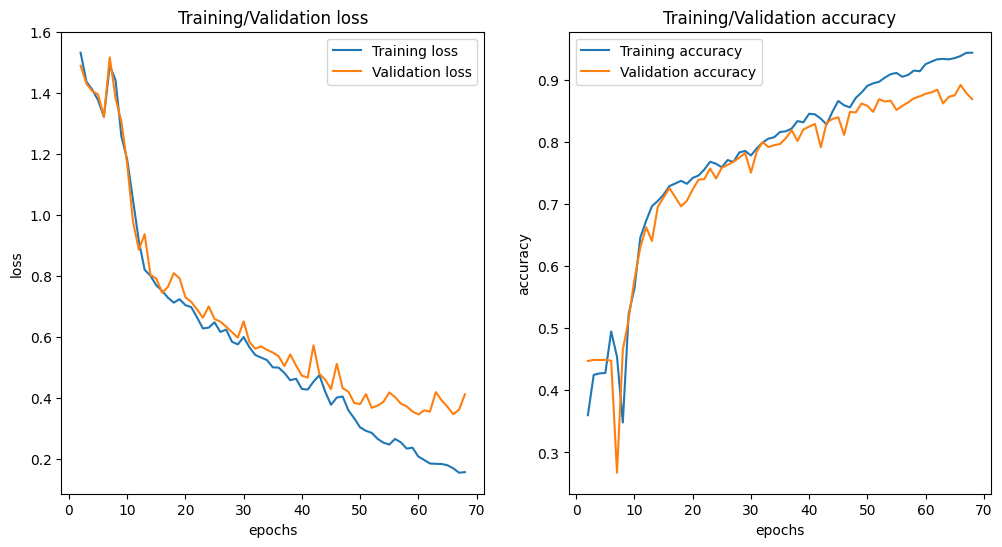

In [82]:
# 결과 시각화


epochs = range(1, len(history.history["loss"]) + 1)[1:]
loss = history.history["loss"][1:]
val_loss = history.history["val_loss"][1:]
acc = history.history["accuracy"][1:]
val_acc = history.history["val_accuracy"][1:]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training/Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training/Validation accuracy")
plt.legend()

In [83]:
from tensorflow.keras.layers import Dropout, Conv2DTranspose

def get_model(img_size, num_classes, dropout_rate=0.1):

    inputs = Input(shape=img_size + (3,))
    rs = Rescaling(1./255)(inputs)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(rs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = Dropout(dropout_rate)(c5)  # Dropout 추가

    u6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(c9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = get_model(img_size=img_size, num_classes=6)
model.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 272, 480, 3)]        0         []                            
                                                                                                  
 rescaling_15 (Rescaling)    (None, 272, 480, 3)          0         ['input_12[0][0]']            
                                                                                                  
 conv2d_298 (Conv2D)         (None, 272, 480, 64)         1792      ['rescaling_15[0][0]']        
                                                                                                  
 conv2d_299 (Conv2D)         (None, 272, 480, 64)         36928     ['conv2d_298[0][0]']          
                                                                                           

In [84]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [TensorBoard(log_dir='./log'), ModelCheckpoint("segmentation.h5", save_best_only=True), EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
history = model.fit(train_input_imgs, train_targets,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=16,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/100
10/10 [==============================] - 26s 926ms/step - loss: 1.9222 - accuracy: 0.3190 - val_loss: 1.6585 - val_accuracy: 0.2377
Epoch 2/100
10/10 [==============================] - 7s 717ms/step - loss: 1.6419 - accuracy: 0.2750 - val_loss: 1.5833 - val_accuracy: 0.2377
Epoch 3/100
10/10 [==============================] - 7s 716ms/step - loss: 1.5474 - accuracy: 0.3530 - val_loss: 1.4561 - val_accuracy: 0.4461
Epoch 4/100
10/10 [==============================] - 7s 736ms/step - loss: 1.4662 - accuracy: 0.4239 - val_loss: 1.4304 - val_accuracy: 0.4461
Epoch 5/100
10/10 [==============================] - 7s 720ms/step - loss: 1.4235 - accuracy: 0.4181 - val_loss: 1.4167 - val_accuracy: 0.3946
Epoch 6/100
10/10 [==============================] - 7s 716ms/step - loss: 1.3797 - accuracy: 0.4002 - val_loss: 1.3602 - val_accuracy: 0.4189
Epoch 7/100
10/10 [==============================] - 7s 718ms/step - loss: 1.2911 - accuracy: 0.4253 - val_loss: 1.2278 - val_accuracy: 0.500

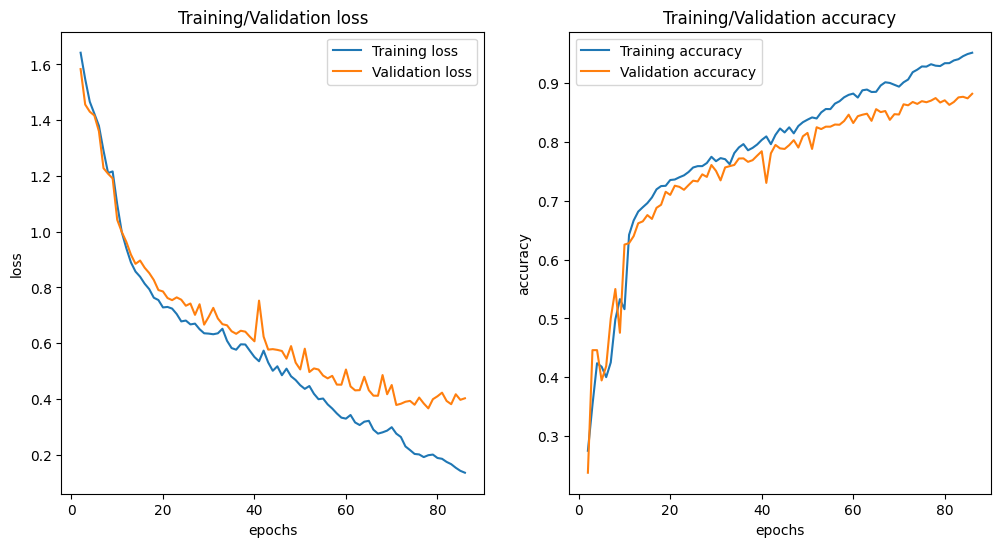

In [85]:
# 결과 시각화

epochs = range(1, len(history.history["loss"]) + 1)[1:]
loss = history.history["loss"][1:]
val_loss = history.history["val_loss"][1:]
acc = history.history["accuracy"][1:]
val_acc = history.history["val_accuracy"][1:]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training/Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training/Validation accuracy")
plt.legend()

In [86]:
from tensorflow.keras.models import load_model

model_path = 'segmentation.h5'

loaded_model = load_model(model_path)
loaded_model.evaluate(test_input_imgs, test_targets)

1/1 [==============================] - 9s 9s/step - loss: 0.3017 - accuracy: 0.8951


[0.301726371049881, 0.895127534866333]

In [87]:
prediction = loaded_model.predict(test_input_imgs)

1/1 [==============================] - 0s 296ms/step


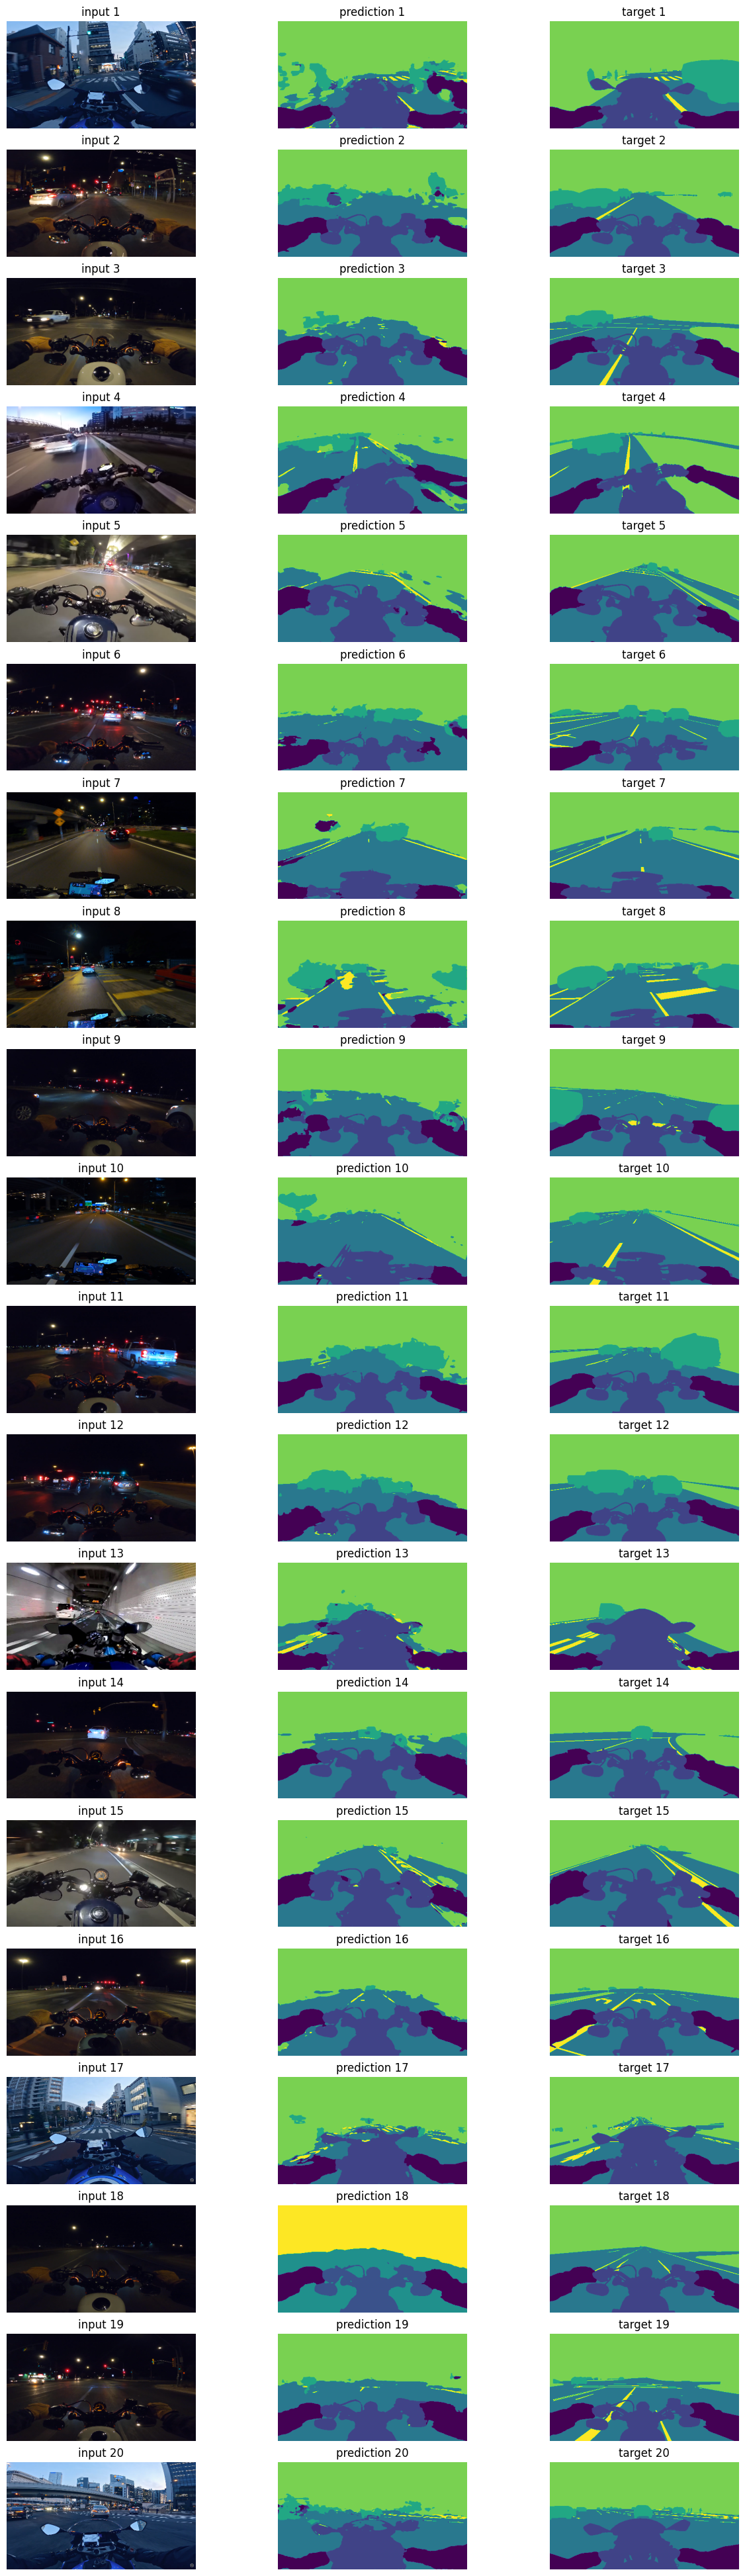

In [88]:
# 모델의 예측 결과 시각화

def convert_output(pred):
    out = np.argmax(pred, axis=-1)
    return out

plt.figure(figsize=(15,50))

for i in range(20):
    plt.subplot(20,3,3*i+1)
    plt.axis('off')
    plt.imshow(test_input_imgs[i]/255)
    plt.title(f'input {i+1}')

    plt.subplot(20,3,3*i+2)
    plt.axis('off')
    output = prediction[i]
    output_img = convert_output(output)
    plt.imshow(output_img)
    plt.title(f'prediction {i+1}')

    plt.subplot(20,3,3*i+3)
    plt.axis('off')
    plt.imshow(test_targets[i])
    plt.title(f'target {i+1}')